## 0) Setup & Imports

In [1]:


# !pip install torch torchvision scikit-learn xgboost matplotlib pandas --quiet

import os, random, math, time, copy
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from xgboost import XGBClassifier

## 1) Configuration & Reproducibility

In [2]:

# ===== USER: set dataset root that contains the single 'train' folder =====
DATA_ROOT = "./"      # e.g. "/path/to/dataset_root"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")

# Splits (only a 'train/' tree exists; we split it into train/val/test)
SPLITS = (0.70, 0.15, 0.15)  # train/val/test
assert abs(sum(SPLITS) - 1.0) < 1e-6

# Image & training settings (tweakable)
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 8                # keep reasonably small to fit <~1 hour on mid-range GPU/CPU
LR = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2 if os.name != "nt" else 0  # Windows often safer with 0 workers

# Small activation dictionary for quick experiments
ACTS = {
    "relu": nn.ReLU(inplace=True),
    "leakyrelu": nn.LeakyReLU(0.1, inplace=True),
    "tanh": nn.Tanh()
}

def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Device:", DEVICE)

Device: cpu


## 2) Transforms & Loading the Single train/ Folder

In [3]:

# Standard normalization (ImageNet stats are a solid default for RGB photos)
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # light augmentation helps generalization
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Load the only available folder (subfolders = class names)
full_dataset_for_split = datasets.ImageFolder(root=TRAIN_DIR, transform=eval_tfms)

# We need labels array for stratified split
all_targets = np.array([y for _, y in full_dataset_for_split.samples], dtype=int)
num_classes = len(full_dataset_for_split.classes)
class_names = full_dataset_for_split.classes
print("Classes:", class_names, " (#:", num_classes, ")")
print("Total images:", len(full_dataset_for_split))

Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']  (#: 12 )
Total images: 4750


## 3) Create Stratified Train/Val/Test Splits (70/15/15)

In [4]:

def stratified_split_indices(y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    n = len(y)

    # First split: train vs temp (val+test)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(1.0 - train_ratio), random_state=seed)
    train_idx, temp_idx = next(sss1.split(np.zeros(n), y))
    y_temp = y[temp_idx]

    # Second split: val vs test from temp, preserving class ratios
    test_ratio_adj = test_ratio / (val_ratio + test_ratio)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio_adj, random_state=seed)
    val_subidx, test_subidx = next(sss2.split(np.zeros(len(temp_idx)), y_temp))

    val_idx = temp_idx[val_subidx]
    test_idx = temp_idx[test_subidx]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_split_indices(all_targets, *SPLITS)
len(train_idx), len(val_idx), len(test_idx)

(3324, 713, 713)

## 4) Build Datasets & DataLoaders per Split

In [5]:

# Reuse the folder paths but attach different transforms per split
# Train uses augmentation; val/test use eval_tfms
base_imgfolder = datasets.ImageFolder(root=TRAIN_DIR, transform=None)

train_ds = copy.copy(base_imgfolder); train_ds.transform = train_tfms
val_ds   = copy.copy(base_imgfolder); val_ds.transform   = eval_tfms
test_ds  = copy.copy(base_imgfolder); test_ds.transform  = eval_tfms

train_ds = Subset(train_ds, train_idx)
val_ds   = Subset(val_ds,   val_idx)
test_ds  = Subset(test_ds,  test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(DEVICE=="cuda"))

print(f"Split sizes -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Split sizes -> Train: 3324, Val: 713, Test: 713


## 5) CNN Model (configurable for quick experiments)

In [9]:
class SimpleCNN(nn.Module):
    """
    Safe + flexible CNN:
      - per-block stride (stride1, stride2)
      - odd kernels only (3/5/7)
      - AdaptiveAvgPool2d(1) keeps FC input stable (no shape errors)
    """
    def __init__(self, num_classes, base_filters=32, kernel_size=3,
                 stride1=1, stride2=1, pool=2, act="relu", feature_dim=128):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Use an ODD kernel_size (3/5/7) to keep padding safe")
        pad = kernel_size // 2

        self.act = ACTS[act]
        self.pool = nn.MaxPool2d(kernel_size=pool, stride=pool) if pool and pool > 1 else nn.Identity()

        self.conv1 = nn.Conv2d(3, base_filters, kernel_size=kernel_size, stride=stride1, padding=pad)
        self.conv2 = nn.Conv2d(base_filters, base_filters*2, kernel_size=kernel_size, stride=stride2, padding=pad)

        self.gap = nn.AdaptiveAvgPool2d((1,1))  # guarantees stable FC input
        self.fc1 = nn.Linear(base_filters*2, feature_dim)
        self.fc_out = nn.Linear(feature_dim, num_classes)

    def forward(self, x, return_features=False):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        feats = self.act(self.fc1(x))
        logits = self.fc_out(feats)
        return (feats, logits) if return_features else logits


## 6) Training & Evaluation Utilities

In [20]:

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_logits, all_labels = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
    avg_loss = running_loss/total
    acc = correct/total
    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return avg_loss, acc, all_logits, all_labels

def train_model(config, train_loader, val_loader, num_classes, epochs=8, lr=1e-3, wd=1e-4, device="cpu"):
    model = SimpleCNN(num_classes=num_classes,
                      base_filters=config["base_filters"],
                      kernel_size=config["kernel"],
                      stride1=config.get("stride1", 1),
                      stride2=config.get("stride2", 1),
                      pool=config["pool"],
                      act=config["act"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc = -np.inf
    best_state = None
    history = []

    def _sync():
        if device == "cuda" and torch.cuda.is_available():
            torch.cuda.synchronize()

    for ep in range(1, epochs+1):
        _sync(); t0 = time.time()
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_acc, _, _ = eval_epoch(model, val_loader, criterion, device)
        _sync(); t1 = time.time()
        ep_time = t1 - t0

        history.append((ep, tr_loss, tr_acc, va_loss, va_acc, ep_time))
        if va_acc > best_val_acc:
            best_val_acc = va_acc
            best_state = copy.deepcopy(model.state_dict())

        print(f"[{config['name']}] Epoch {ep:02d}/{epochs} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.3f} | "
              f"time {ep_time:.2f}s")

    model.load_state_dict(best_state)
    return model, pd.DataFrame(history, columns=["epoch","train_loss","train_acc","val_loss","val_acc","epoch_time_sec"])

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def get_features(model, loader, device):
    model.eval()
    feats_list, labels_list = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        feats, logits = model(imgs, return_features=True)
        feats_list.append(feats.cpu().numpy())
        labels_list.append(labels.numpy())
    return np.vstack(feats_list), np.hstack(labels_list)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

def compute_metrics(y_true, y_pred, y_proba, num_classes):
    """
    y_true:    (N,) integer class ids
    y_pred:    (N,) integer class ids
    y_proba:   (N, C) class probabilities/scores for ROC-AUC (ovr)
    num_classes: int

    Returns a dict with micro/macro/weighted metrics and ROC-AUC (ovr).
    Note: In single-label multiclass, micro-F1 == accuracy by definition.
    """
    # ---- Micro (global) ----
    acc           = accuracy_score(y_true, y_pred)
    prec_micro    = precision_score(y_true, y_pred, average="micro", zero_division=0)
    rec_micro     = recall_score(y_true, y_pred, average="micro", zero_division=0)
    f1_micro      = f1_score(y_true, y_pred, average="micro", zero_division=0)

    # ---- Macro (equal weight per class) ----
    prec_macro    = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro     = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro      = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # ---- Weighted (weighted by support) ----
    prec_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec_weighted  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1_weighted   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    # ---- ROC-AUC (one-vs-rest) ----
    # Needs probabilities; if unavailable, set to NaN.
    try:
        # If y_proba are logits, softmaxed probabilities may be passed.
        roc = roc_auc_score(
            y_true, y_proba, multi_class="ovr", average="macro"
        )
    except Exception:
        roc = float("nan")

    return {
        # micro
        "accuracy": acc,
        "precision_micro": prec_micro,
        "recall_micro": rec_micro,
        "f1_micro": f1_micro,
        # macro
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        # weighted
        "precision_weighted": prec_weighted,
        "recall_weighted": rec_weighted,
        "f1_weighted": f1_weighted,
        # auc
        "roc_auc_ovr": roc,
    }


def softmax_np(logits):
    e = np.exp(logits - logits.max(axis=1, keepdims=True))
    return e / e.sum(axis=1, keepdims=True)

## 7) Hyperparameter Experiments (Baseline CNN variants)


=== Training: relu_k3_b32_s11 ===
[relu_k3_b32_s11] Epoch 01/8 | train loss 2.4230 acc 0.138 | val loss 2.3677 acc 0.191 | time 145.08s
[relu_k3_b32_s11] Epoch 02/8 | train loss 2.3491 acc 0.176 | val loss 2.2398 acc 0.234 | time 130.44s
[relu_k3_b32_s11] Epoch 03/8 | train loss 2.0394 acc 0.252 | val loss 1.8924 acc 0.278 | time 117.99s
[relu_k3_b32_s11] Epoch 04/8 | train loss 1.8438 acc 0.311 | val loss 1.8670 acc 0.320 | time 115.70s
[relu_k3_b32_s11] Epoch 05/8 | train loss 1.7434 acc 0.356 | val loss 1.6820 acc 0.384 | time 115.84s
[relu_k3_b32_s11] Epoch 06/8 | train loss 1.6564 acc 0.412 | val loss 1.6018 acc 0.466 | time 111.47s
[relu_k3_b32_s11] Epoch 07/8 | train loss 1.5684 acc 0.446 | val loss 1.5556 acc 0.429 | time 108.17s
[relu_k3_b32_s11] Epoch 08/8 | train loss 1.5002 acc 0.473 | val loss 1.4538 acc 0.496 | time 106.67s

=== Training: relu_k3_b48_s11 ===
[relu_k3_b48_s11] Epoch 01/8 | train loss 2.4108 acc 0.140 | val loss 2.3547 acc 0.184 | time 141.74s
[relu_k3_b48

,accuracy,precision_micro,recall_micro,f1_micro,roc_auc_ovr,model,split
3,0.551192,0.551192,0.551192,0.551192,0.907959,leaky_k3_b32_s11,val
2,0.541374,0.541374,0.541374,0.541374,0.909211,relu_k5_b32_s11,val
7,0.523142,0.523142,0.523142,0.523142,0.901689,tanh_k3_b32_s21,val
5,0.514727,0.514727,0.514727,0.514727,0.904503,relu_k3_b32_s21,val
6,0.500701,0.500701,0.500701,0.500701,0.895828,relu_k3_b32_s22,val
0,0.496494,0.496494,0.496494,0.496494,0.886393,relu_k3_b32_s11,val
4,0.478261,0.478261,0.478261,0.478261,0.890901,tanh_k3_b32_s11,val
1,0.457223,0.457223,0.457223,0.457223,0.876600,relu_k3_b48_s11,val


,accuracy,precision_micro,recall_micro,f1_micro,roc_auc_ovr,model,split,mean_epoch_sec,total_train_sec,params
0,0.551192,0.551192,0.551192,0.551192,0.907959,leaky_k3_b32_s11,val,111.613797,892.910379,29260
1,0.541374,0.541374,0.541374,0.541374,0.909211,relu_k5_b32_s11,val,133.188950,1065.511604,63564
2,0.523142,0.523142,0.523142,0.523142,0.901689,tanh_k3_b32_s21,val,69.592425,556.739397,29260
3,0.514727,0.514727,0.514727,0.514727,0.904503,relu_k3_b32_s21,val,88.189330,705.514639,29260
4,0.500701,0.500701,0.500701,0.500701,0.895828,relu_k3_b32_s22,val,67.588891,540.711128,29260
5,0.496494,0.496494,0.496494,0.496494,0.886393,relu_k3_b32_s11,val,118.921255,951.370038,29260
6,0.478261,0.478261,0.478261,0.478261,0.890901,tanh_k3_b32_s11,val,152.418341,1219.346732,29260
7,0.457223,0.457223,0.457223,0.457223,0.876600,relu_k3_b48_s11,val,147.562106,1180.496847,56876


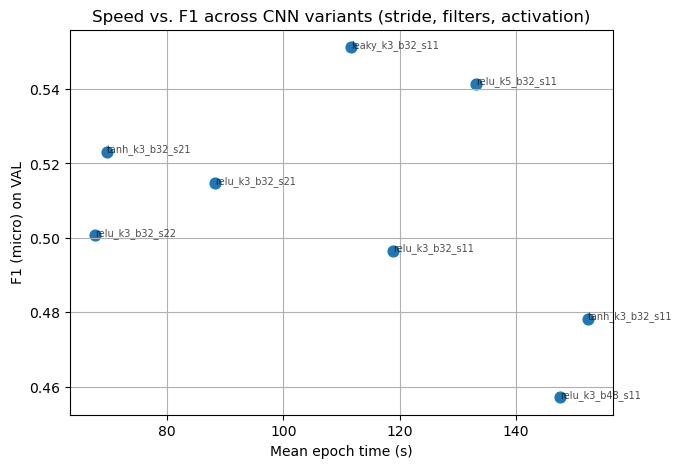

In [13]:
# 1) Experiments list
experiments = [
    {"name":"relu_k3_b32_s11", "act":"relu", "base_filters":32, "kernel":3, "pool":2, "stride1":1, "stride2":1},
    {"name":"relu_k3_b48_s11", "act":"relu", "base_filters":48, "kernel":3, "pool":2, "stride1":1, "stride2":1},
    {"name":"relu_k5_b32_s11", "act":"relu", "base_filters":32, "kernel":5, "pool":2, "stride1":1, "stride2":1},
    {"name":"leaky_k3_b32_s11","act":"leakyrelu", "base_filters":32, "kernel":3, "pool":2, "stride1":1, "stride2":1},
    {"name":"tanh_k3_b32_s11", "act":"tanh", "base_filters":32, "kernel":3, "pool":2, "stride1":1, "stride2":1},
    {"name":"relu_k3_b32_s21", "act":"relu", "base_filters":32, "kernel":3, "pool":2, "stride1":2, "stride2":1},
    {"name":"relu_k3_b32_s22", "act":"relu", "base_filters":32, "kernel":3, "pool":1, "stride1":2, "stride2":2}, # no pooling
    {"name":"tanh_k3_b32_s21", "act":"tanh", "base_filters":32, "kernel":3, "pool":2, "stride1":2, "stride2":1},
]

# 2) Init containers
results = []
trained_models = {}
histories = {}
param_counts = {}

# 3) Training loop
for cfg in experiments:
    print("\n=== Training:", cfg["name"], "===")
    model, hist = train_model(cfg, train_loader, val_loader, num_classes,
                              epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY, device=DEVICE)

    histories[cfg["name"]] = hist.copy()
    trained_models[cfg["name"]] = model
    param_counts[cfg["name"]] = count_params(model)

    # Validation metrics
    criterion = nn.CrossEntropyLoss()
    val_loss, val_acc, val_logits, val_labels = eval_epoch(model, val_loader, criterion, DEVICE)
    val_proba = softmax_np(val_logits)
    val_pred  = val_logits.argmax(axis=1)
    val_metrics = compute_metrics(val_labels, val_pred, val_proba, num_classes)
    val_metrics["model"] = cfg["name"]
    val_metrics["split"] = "val"
    results.append(val_metrics)

# 4) Build df_results
df_results = pd.DataFrame(results).sort_values(by=["split","f1_micro"], ascending=[True,False])
display(df_results)

# 5) Timing summary
time_summaries = []
for name, hist in histories.items():
    mean_t = hist["epoch_time_sec"].mean()
    total_t = hist["epoch_time_sec"].sum()
    time_summaries.append({
        "model": name,
        "mean_epoch_sec": mean_t,
        "total_train_sec": total_t,
        "params": param_counts.get(name, None)
    })

df_times = pd.DataFrame(time_summaries)

# Merge with df_results
df_val = df_results[df_results["split"]=="val"].copy()
df_val = df_val.merge(df_times, on="model", how="left")
df_val.sort_values(["f1_micro","mean_epoch_sec"], ascending=[False,True], inplace=True)
df_val.reset_index(drop=True, inplace=True)
display(df_val)

# 6) Plot
plt.figure(figsize=(7,5))
plt.scatter(df_val["mean_epoch_sec"], df_val["f1_micro"], s=60)
for _, r in df_val.iterrows():
    plt.annotate(r["model"], (r["mean_epoch_sec"], r["f1_micro"]), fontsize=7, alpha=0.7)
plt.xlabel("Mean epoch time (s)")
plt.ylabel("F1 (micro) on VAL")
plt.title("Speed vs. F1 across CNN variants (stride, filters, activation)")
plt.grid(True)
plt.show()


## 8) Pick one CNN to Evaluate on TEST (and to Extract Features)

In [21]:

# Choose the best variant by validation F1 (micro)
best_name = df_results.loc[df_results["split"]=="val"].sort_values("f1_micro", ascending=False).iloc[0]["model"]
best_model = trained_models[best_name]
print("Best CNN on VAL:", best_name)

# Final evaluation on TEST
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_logits, test_labels = eval_epoch(best_model, test_loader, criterion, DEVICE)
test_proba = softmax_np(test_logits)
test_pred  = test_logits.argmax(axis=1)

cnn_metrics_test = compute_metrics(test_labels, test_pred, test_proba, num_classes)
cnn_metrics_test["model"] = f"{best_name}__softmax"
cnn_metrics_test["split"] = "test"
cnn_metrics_test

Best CNN on VAL: leaky_k3_b32_s11


{'accuracy': 0.5708274894810659,
 'precision_micro': 0.5708274894810659,
 'recall_micro': 0.5708274894810659,
 'f1_micro': 0.5708274894810659,
 'precision_macro': 0.5445585292636185,
 'recall_macro': 0.5140574683135213,
 'f1_macro': 0.509678327677778,
 'precision_weighted': 0.5499647193350014,
 'recall_weighted': 0.5708274894810659,
 'f1_weighted': 0.5446420162162939,
 'roc_auc_ovr': 0.9102827174706539,
 'model': 'leaky_k3_b32_s11__softmax',
 'split': 'test'}

## 9) CNN → Feature Extraction → Train SVM & XGBoost

In [22]:

# Extract features from TRAIN and TEST using the best CNN
train_feats, train_y = get_features(best_model, train_loader, DEVICE)
test_feats,  test_y  = get_features(best_model, test_loader,  DEVICE)

print("Feature shapes:", train_feats.shape, test_feats.shape)

# --- SVM (RBF, probability=True for ROC-AUC) ---
svm = SVC(kernel="rbf", C=2.0, gamma="scale", probability=True, random_state=42)
svm.fit(train_feats, train_y)
svm_pred  = svm.predict(test_feats)
svm_proba = svm.predict_proba(test_feats)
svm_metrics = compute_metrics(test_y, svm_pred, svm_proba, num_classes)
svm_metrics["model"] = f"{best_name}__SVM"
svm_metrics["split"] = "test"

# --- XGBoost (multi-class, modest params to keep fast) ---
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",        # fast on CPU
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(train_feats, train_y)
xgb_pred  = xgb.predict(test_feats)
xgb_proba = xgb.predict_proba(test_feats)
xgb_metrics = compute_metrics(test_y, xgb_pred, xgb_proba, num_classes)
xgb_metrics["model"] = f"{best_name}__XGBoost"
xgb_metrics["split"] = "test"

pd.DataFrame([cnn_metrics_test, svm_metrics, xgb_metrics])

Feature shapes: (3324, 128) (713, 128)


,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,roc_auc_ovr,model,split
0,0.570827,0.570827,0.570827,0.570827,0.544559,0.514057,0.509678,0.549965,0.570827,0.544642,0.910283,leaky_k3_b32_s11__softmax,test
1,0.603086,0.603086,0.603086,0.603086,0.550937,0.546457,0.532241,0.569002,0.603086,0.573231,0.932936,leaky_k3_b32_s11__SVM,test
2,0.621318,0.621318,0.621318,0.621318,0.599423,0.582385,0.579871,0.616181,0.621318,0.608752,0.941587,leaky_k3_b32_s11__XGBoost,test


## 10) Comparison Table (Test Set)

In [23]:

summary = pd.DataFrame([cnn_metrics_test, svm_metrics, xgb_metrics])[
    ["model",
     "accuracy",
     "f1_micro",
     "f1_macro",
     "f1_weighted",
     "roc_auc_ovr",
    ]
].sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
summary



,model,accuracy,f1_micro,f1_macro,f1_weighted,roc_auc_ovr
0,leaky_k3_b32_s11__XGBoost,0.621318,0.621318,0.579871,0.608752,0.941587
1,leaky_k3_b32_s11__SVM,0.603086,0.603086,0.532241,0.573231,0.932936
2,leaky_k3_b32_s11__softmax,0.570827,0.570827,0.509678,0.544642,0.910283


## 11) ROC Curves (One-vs-Rest, Test Set)

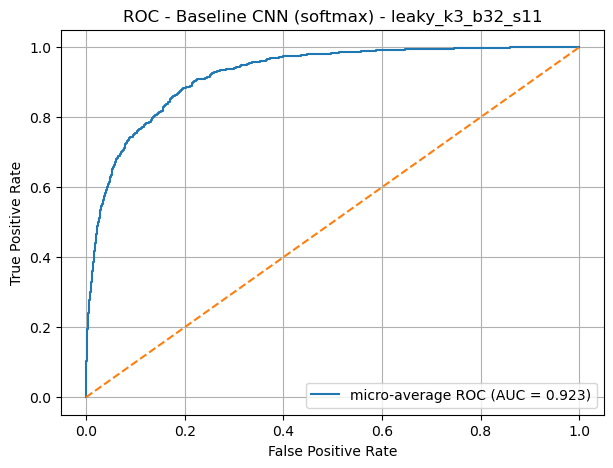

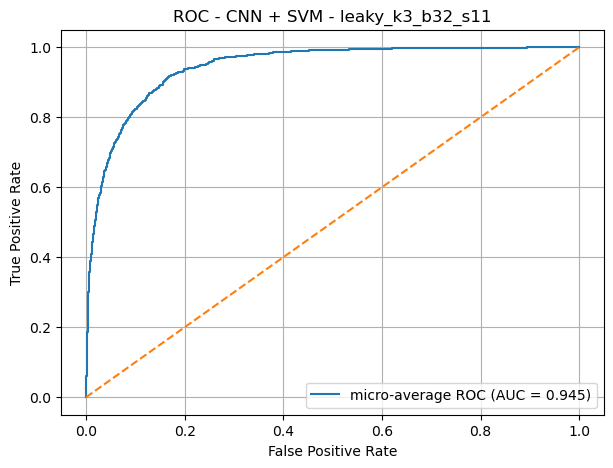

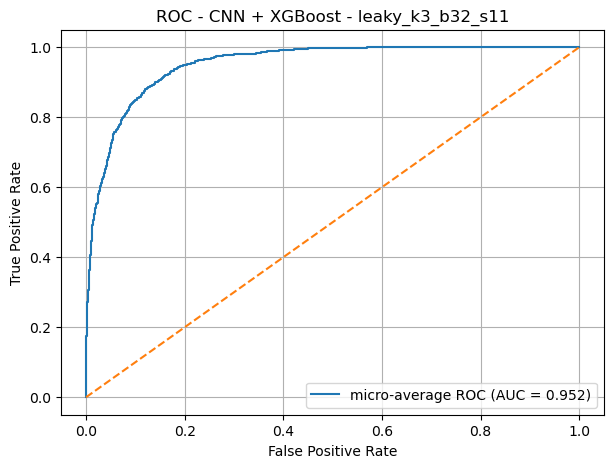

In [24]:

def plot_roc_ovr(y_true, proba, title):
    y_bin = label_binarize(y_true, classes=list(range(num_classes)))
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for c in range(num_classes):
        fpr[c], tpr[c], _ = roc_curve(y_bin[:, c], proba[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(7,5))
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC (AUC = {roc_auc['micro']:.3f})")

    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# ROC for each approach:
plot_roc_ovr(test_labels, test_proba, f"ROC - Baseline CNN (softmax) - {best_name}")
plot_roc_ovr(test_y, svm_proba, f"ROC - CNN + SVM - {best_name}")
plot_roc_ovr(test_y, xgb_proba, f"ROC - CNN + XGBoost - {best_name}")

## 13) Tiny Grid Search Hooks You Can Expand

In [25]:
# quick SVM C sweep on CNN features
# (Run after computing train_feats/test_feats)
for C in [0.5, 1.0, 2.0, 4.0]:
    svm_t = SVC(kernel="rbf", C=C, gamma="scale", probability=True, random_state=42)
    svm_t.fit(train_feats, train_y)
    pred = svm_t.predict(test_feats)
    proba = svm_t.predict_proba(test_feats)
    m = compute_metrics(test_y, pred, proba, num_classes)
    print(f"SVM C={C}: F1_micro={m['f1_micro']:.3f} | Acc={m['accuracy']:.3f} | ROC_AUC={m['roc_auc_ovr']:.3f}")


SVM C=0.5: F1_micro=0.581 | Acc=0.581 | ROC_AUC=0.927
SVM C=1.0: F1_micro=0.592 | Acc=0.592 | ROC_AUC=0.930
SVM C=2.0: F1_micro=0.603 | Acc=0.603 | ROC_AUC=0.933
SVM C=4.0: F1_micro=0.619 | Acc=0.619 | ROC_AUC=0.935
